
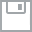
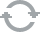
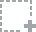
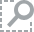
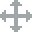
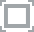
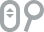
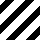
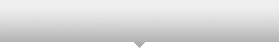
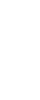
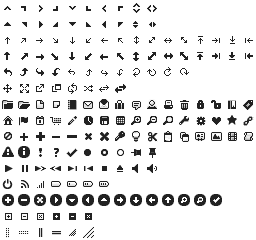
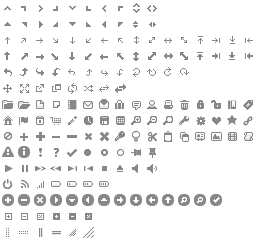
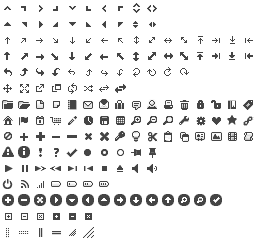
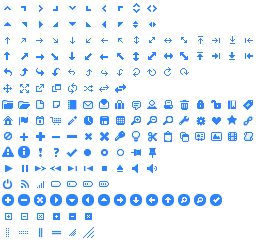
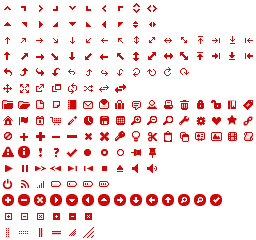
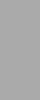
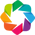
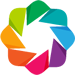

In [1]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import PuBuGn9 as Palette
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

output_notebook()

I'm originally from North Carolina, and I've been hearing a lot of people talking about how often it's been raining recently. They're excited for any day that has sun.

So I got a bit curious: Has North Carolina over the past few months actually had more cloudy and rainy days recently than in previous years? This shouldn't be a particularly challenging task, but I'm interested to know if people's perceptions actually reflect reality.

The data we'll use comes from [forecast.io][1], since they can give us a cloud cover percentage. I've gone ahead and retrieved the data to a pickle file, and included the [code that was used to generate it](#Generating-the-Forecast-file). First up: What was the average cloud cover in North Carolina during August - November, and how many days were cloudy? We're going to assume that a "cloudy" day is defined as any day in which the cloud cover is above 50%.

[1]: http://forecast.io/

In [2]:
city_forecasts = pickle.load(open('city_forecasts.p', 'rb'))
forecast_df = pd.DataFrame.from_dict(city_forecasts)

In [3]:
cary_forecast = forecast_df['cary']
years = range(1990, 2016)
months = range(7, 12)
months_str = ['July', 'August', 'September', 'October', 'November']

def safe_cover(frame):
    if frame and 'cloudCover' in frame:
        return frame['cloudCover']
    else:
        return np.NaN

def monthly_avg_cloudcover(year, month):
    dates = pd.DatetimeIndex(start=datetime(year, month, 1, 12),
                             end=datetime(year, month + 1, 1, 12),
                             freq='D', closed='left')
    cloud_cover_vals = list(map(lambda x: safe_cover(cary_forecast[x]['currently']), dates))
    cloud_cover_samples = len(list(filter(lambda x: x is not np.NaN, cloud_cover_vals)))
    return np.nanmean(cloud_cover_vals), cloud_cover_samples


monthly_cover_vals = [[monthly_avg_cloudcover(y, m)[0] for y in years] for m in months]

f = figure(title='Monthly Average Cloud Cover',
           x_range=(1990, 2015),
          x_axis_label='Year')
for x in range(0, len(months)):
    f.line(years, monthly_cover_vals[x], legend=months_str[x], color=Palette[x])
show(f)

As we can see from the chart above, on the whole the monthly average cloud cover has been generally trending down over time. The average cloud cover is also lower than it was last year - it seems people are mostly just complaining. There are some data issues that start in 2012 that we need to be aware of - the cloud cover percentage doesn't exist for all days. Even so, the data that we have seems to reflect the wider trend, so we'll assume for now that the missing data doesn't skew our results.

There's one more metric we want to check though - how many cloudy days were there? This is probably a better gauge of sentiment than the average monthly cover.

In [4]:
def monthly_cloudy_days(year, month):
    dates = pd.DatetimeIndex(start=datetime(year, month, 1, 12),
                             end=datetime(year, month + 1, 1, 12),
                             freq='D', closed='left')
    cloud_cover_vals = list(map(lambda x: safe_cover(cary_forecast[x]['currently']), dates))
    cloud_cover_samples = len(list(filter(lambda x: x is not np.NaN, cloud_cover_vals)))
    cloudy_days = [cover > .5 for cover in cloud_cover_vals]
    return np.count_nonzero(cloudy_days), cloud_cover_samples

monthly_days_vals = [[monthly_cloudy_days(y, m)[0] for y in years] for m in months]
monthly_cover_samples = [[monthly_cloudy_days(y, m)[1] for y in years] for m in months]

f = figure(title='Monthly Cloudy Days',
           x_range=(1990, 2015),
          x_axis_label='Year')
for x in range(0, len(months)):
    f.line(years, monthly_days_vals[x], legend=months_str[x], color=Palette[x])
show(f)

f = figure(title='Monthly Cloud Cover Samples',
          x_range=(1990, 2015),
          x_axis_label='Year',
          height=300)
for x in range(0, len(months)):
    f.line(years, monthly_cover_samples[x], legend=months_str[x], color=Palette[x])
show(f)

On the whole, the number of cloudy days seems to reflect the trend with average cloud cover - it's actually becoming more sunny as time progresses. That said, we need to be careful in how we view this number - because there weren't as many samples in 2015 as previous years, the number of days can get thrown off. In context though, even if most days not recorded were in fact cloudy, the overall count for 2015 would still be lower than previous years.

# Tracking Precipitation Chances

In addition to checking cloud cover, I wanted to check precipitation data as well - what is the average precipitation chance over a month, and how many days during a month is rain likely? The thinking is that days with a high-precipitation chance will also be days in which it is cloudy or depressing.

In [5]:
def safe_precip(frame):
    if frame and 'precipProbability' in frame:
        return frame['precipProbability']
    else:
        return np.NaN

def monthly_avg_precip(year, month):
    dates = pd.DatetimeIndex(start=datetime(year, month, 1, 12),
                             end=datetime(year, month + 1, 1, 12),
                             freq='D', closed='left')
    precip_vals = list(map(lambda x: safe_precip(cary_forecast[x]['currently']), dates))
    precip_samples = len(list(filter(lambda x: x is not np.NaN, precip_vals)))
    return np.nanmean(precip_vals), precip_samples

monthly_avg_precip_vals = [[monthly_avg_precip(y, m)[0] for y in years] for m in months]

f = figure(title='Monthly Average Precipitation Chance',
           x_range=(1990, 2015),
          x_axis_label='Year')
for x in range(0, len(months)):
    f.line(years, monthly_avg_precip_vals[x], legend=months_str[x], color=Palette[x])
show(f)

As we can see from the chart, the average chance of precipitation over a month more or less stays within a band of 0 - .1 for all months over all years. This is further evidence that the past few months are no more cloudy or rainy than previous years. Like the cloud cover though, we still want to get a count of all the rainy days, in addition to the average chance. We'll define a "rainy day" as any day in which the chance of rain is greater than 25%.

In [6]:
def monthly_rainy_days(year, month):
    dates = pd.DatetimeIndex(start=datetime(year, month, 1, 12),
                             end=datetime(year, month + 1, 1, 12),
                             freq='D', closed='left')
    precip_prob_vals = list(map(lambda x: safe_precip(cary_forecast[x]['currently']), dates))
    precip_prob_samples = len(list(filter(lambda x: x is not np.NaN, precip_prob_vals)))
    precip_days = [prob > .25 for prob in precip_prob_vals]
    return np.count_nonzero(precip_days), precip_prob_samples

monthly_precip_days_vals = [[monthly_rainy_days(y, m)[0] for y in years] for m in months]
monthly_precip_samples = [[monthly_rainy_days(y, m)[1] for y in years] for m in months]

f = figure(title='Monthly Rainy Days',
           x_range=(1990, 2015),
          x_axis_label='Year')
for x in range(0, len(months)):
    f.line(years, monthly_precip_days_vals[x], legend=months_str[x], color=Palette[x])
show(f)

f = figure(title='Monthly Rainy Days Samples',
          x_range=(1990, 2015),
          x_axis_label='Year',
          height=300)
for x in range(0, len(months)):
    f.line(years, monthly_precip_samples[x], legend=months_str[x], color=Palette[x])
show(f)

After trying to find the number of days that are rainy, we can see that November hit its max value for rainy days in 2015. However, that value is 6, as compared to a previous maximum of 5. While it is a new record, the value isn't actually all that different. And for other months, the values are mostly in-line with the averages.

# Summary and Conclusions

After having looked at forecast data for Cary, it appears that the months of July - November this year in terms of weather were at worst on par with prior years, if not slightly more sunny. This seems to be a case of confirmation bias: someone complains about a string of cloudy or rainy days, and suddenly you start noticing them more.

While this analysis doesn't take into account other areas of North Carolina, my initial guess would be to assume that other areas also will show similar results: nothing interesting is happening. Maybe that will be for another blog post later!

Coming soon: I'll compare rain/cloud conditions in North Carolina to some other places in the U.S.!

# Generating the Forecast file

The following code was generates the file that was used throughout the blog post. Please note that I'm retrieving data for other cities to use in a future blog post, only Cary data was used for this post.

```python
import pandas as pd
from functools import reduce
import requests
from datetime import datetime

# Coordinate data from http://itouchmap.com/latlong.html
cary_loc = (35.79154,-78.781117)
nyc_loc = (40.78306,-73.971249)
seattle_loc = (47.60621,-122.332071)
binghamton_loc = (42.098687,-75.917974)
cities = {
    'cary': cary_loc,
    'nyc': nyc_loc,
    'seattle': seattle_loc,
    'binghamton': binghamton_loc
}

apikey = '' # My super-secret API Key

def get_forecast(lat, long, date=None):
    forecast_base = "https://api.forecast.io/forecast/"
    if date is None:
        url = forecast_base + apikey + '/{},{}'.format(lat, long)
    else:
        epoch = int(date.timestamp())
        url = forecast_base + apikey + '/{},{},{}'.format(lat, long, epoch)
        
    return requests.get(url).json()
    
years = range(1990,2016)
# For datetimes, the 12 is for getting the weather at noon.
# We're doing this over midnight because we're more concerned
# with what people see, and people don't typically see the weather
# at midnight.
dt_indices = [pd.date_range(start=datetime(year, 7, 1, 12),
                          end=datetime(year, 11, 30, 12))
              for year in years]
dt_merge = reduce(lambda x, y: x.union(y), dt_indices)

# Because we have to pay a little bit to use the API, we use for loops here
# instead of a comprehension - if something breaks, we want to preserve the
# data already retrieved
city_forecasts = {}
for city, loc in cities.items():
    print("Retrieving data for {} starting at {}".format(city,
                                                         datetime.now().strftime("%I:%M:%S %p")))
    for dt in dt_merge:
        try:
            city_forecasts[(city, dt)] = get_forecast(*loc, dt)
        except Exception as e:
            print(e)
            city_forecasts[(city, dt)] = None
print("End forecast retrieval: {}".format(datetime.now().strftime("%I:%M:%S %p")))

import pickle
pickle.dump(city_forecasts, open('city_forecasts.p', 'wb'))

### Output:
# Retrieving data for binghamton starting at 05:13:42 PM
# Retrieving data for seattle starting at 05:30:51 PM
# Retrieving data for nyc starting at 05:48:30 PM
# Retrieving data for cary starting at 06:08:32 PM
# End forecast retrieval: 06:25:21 PM
```